In [ ]:
import json
import pandas as pd
from collections import defaultdict
import argparse
from datetime import datetime
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

json_path=r"C:\Users\aryan\OneDrive\Desktop\kaggle\aave_proto\user-wallet-transactions.json"
df = pd.read_json(json_path)

In [3]:
print(df['actionData'].apply(lambda x: x.get('assetSymbol', '').upper()).unique())

['USDC' 'WMATIC' 'DAI' 'WBTC' 'WETH' 'USDT' 'WPOL' 'AAVE' '']


In [ ]:
# Token decimal mapping
token_decimals = {
    'USDC': 6,
    'USDT': 6,
    'DAI': 18,
    'WMATIC': 18,
    'WETH': 18,
    'WBTC': 8,
    'WPOL': 18,  
    'AAVE': 18
}

wallet_stats = defaultdict(lambda: {
    'total_deposit_usd': 0.0,
    'total_borrow_usd': 0.0,
    'total_repay_usd': 0.0,
    'total_redeem_usd': 0.0,
    'num_liquidations': 0
})

for _, row in df.iterrows():
    wallet = row['userWallet']
    action = row['action'].lower()
    data = row['actionData']

    if action == 'liquidationcall':
        wallet_stats[wallet]['num_liquidations'] += 1
        continue  

    #process deposit/borrow/repay/redeem
    symbol = data.get('assetSymbol', '').upper()
    if not symbol or symbol not in token_decimals:
        continue 

    decimals = token_decimals[symbol]

    try:
        amount_raw = float(data.get('amount', 0))
        amount = amount_raw / (10 ** decimals)
        price = float(data.get('assetPriceUSD', 0))
        usd_value = amount * price
    except:
        usd_value = 0

    if action == 'deposit':
        wallet_stats[wallet]['total_deposit_usd'] += usd_value
    elif action == 'borrow':
        wallet_stats[wallet]['total_borrow_usd'] += usd_value
    elif action == 'repay':
        wallet_stats[wallet]['total_repay_usd'] += usd_value
    elif action == 'redeemunderlying':
        wallet_stats[wallet]['total_redeem_usd'] += usd_value

# Convert to final dataframe
wallet_df = pd.DataFrame([
    {
        'userWallet': wallet,
        'total_deposit_usd': stats['total_deposit_usd'],
        'total_borrow_usd': stats['total_borrow_usd'],
        'total_repay_usd':stats['total_repay_usd'],
        'repay_ratio': stats['total_repay_usd'] / stats['total_borrow_usd'] if stats['total_borrow_usd'] > 0 else 1.0,
        'total_redeem_usd': stats['total_redeem_usd'],
        'redeem_ratio':stats['total_redeem_usd']/ stats['total_borrow_usd'] if stats['total_borrow_usd'] > 0 else 1.0,
        'num_liquidations': stats['num_liquidations']
    }
    for wallet, stats in wallet_stats.items()
])

In [ ]:
features = ['total_deposit_usd', 'total_borrow_usd', 'repay_ratio', 'total_redeem_usd', 'num_liquidations', 'redeem_ratio']
X = wallet_df[features]

# Step 2: Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Step 3: Define Autoencoder
input_dim = X_scaled.shape[1]
encoding_dim = 3

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Step 4: Train Autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
autoencoder.fit(X_scaled, X_scaled, epochs=100, batch_size=32, verbose=0)

# Step 5: Encode Data to Latent Space
X_encoded = encoder.predict(X_scaled)

# Step 6: Cluster Encoded Features
kmeans = KMeans(n_clusters=5, random_state=42)
wallet_df['cluster'] = kmeans.fit_predict(X_encoded)

wallet_df['raw_score'] = (
    wallet_df['repay_ratio'] * 500 +                     # up to 500 points for repay ratio
    (1 - wallet_df['num_liquidations'] / 10.0) * 200 +   # penalize liquidation
    (wallet_df['total_deposit_usd'] > 1e5) * 100 +       # bonus for high deposits
    wallet_df['redeem_ratio'].clip(0, 1) * 100  # up to 100 points for redeem ratio
)

wallet_df['credit_score'] = wallet_df['raw_score'].clip(0, 1000)

wallet_df.drop('raw_score', axis=1, inplace=True)

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step


In [9]:
wallet_df.head(10)

,userWallet,total_deposit_usd,total_borrow_usd,total_repay_usd,repay_ratio,total_redeem_usd,redeem_ratio,num_liquidations,cluster,credit_score
0,0x00000000001accfa9cef68cf5371a23025b6d4b6,1987.663655,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000
1,0x000000000051d07a4fb3bd10121a343d85818da6,285.694480,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000
2,0x000000000096026fb41fc39f9875d164bd82e2dc,0.005152,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000
3,0x0000000000e189dd664b9ab08a33c4839953852c,0.000000,0.000000,0.000000,1.000000,1960.722952,1.000000,0,0,800.000000
4,0x0000000002032370b971dabd36d72f3e5a7bf1ee,925490.696960,130355.754756,70150.263791,0.538145,824037.577815,6.321451,0,0,669.072370
5,0x000000000a38444e0a6e37d3b630d7e855a7cb13,18390.665686,11631.431210,11640.280240,1.000761,9355.620852,0.804340,0,0,780.814354
6,0x000000003853fcedcd0355fec98ca3192833f00b,0.120063,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000
7,0x000000003ce0cf2c037493b1dc087204bd7f713e,672499.575930,134838.424039,2758.686260,0.020459,507275.639340,3.762100,0,1,410.229600
8,0x000000007858e6f2668e1e06111cfa24403a5466,0.142161,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000
9,0x00000001a0f57e850c9db68b4a9bc34677437c5c,1.766653,0.000000,0.000000,1.000000,0.000000,1.000000,0,0,800.000000


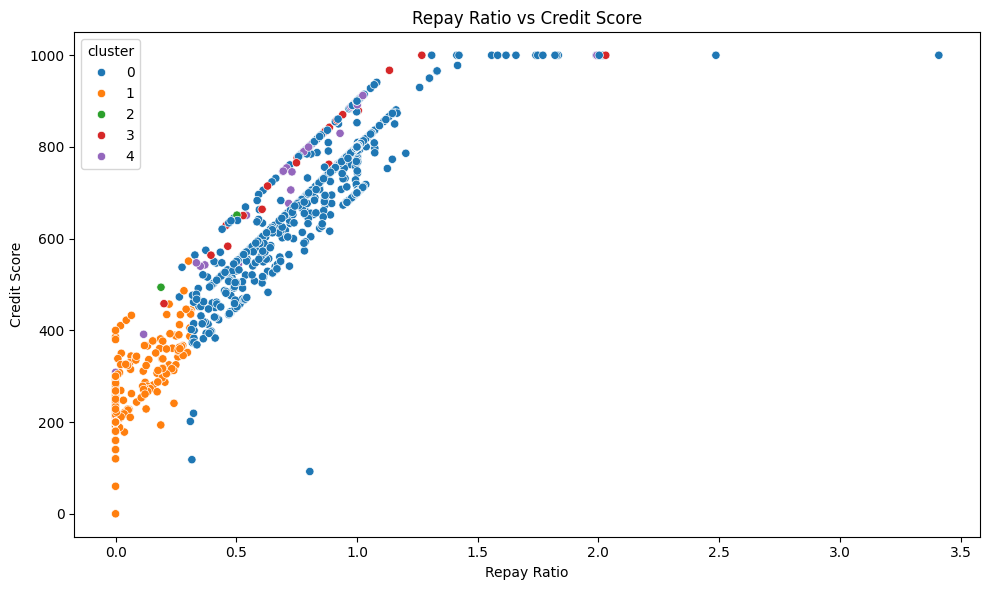

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=wallet_df, x='repay_ratio', y='credit_score', hue='cluster', palette='tab10')
plt.title("Repay Ratio vs Credit Score")
plt.xlabel("Repay Ratio")
plt.ylabel("Credit Score")
plt.tight_layout()
plt.show()

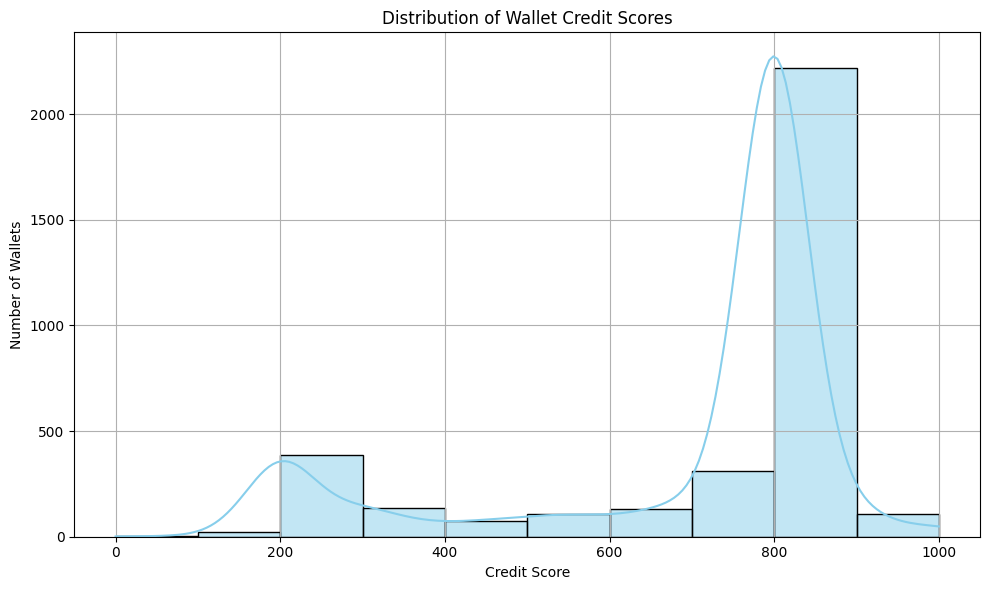

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(wallet_df['credit_score'], bins=10, kde=True, color='skyblue')
plt.title("Distribution of Wallet Credit Scores")
plt.xlabel("Credit Score")
plt.ylabel("Number of Wallets")
plt.grid(True)
plt.tight_layout()
plt.show()